In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Lecture outline
- Opinion dynamics with stubborn agents
- Resistor networks
- Discrete-time Markov chains

# Opinion dynamics with stubborn agents
We study how to simulate the linear averaging dynamics on graphs in presence of stubborn agents.

We focus on the optimal placement problem, which consists of optimally chosing the position of a stubborn node on the graph in order to maximize its influence on the asymptotic outcome of the dynamics.

Let us first summarize the theory in presence of stubborn agents.

We are given a network, where the agents $V$ are divided in regular agents $R$ and stubborn agents $S$. The regular agents update their opinion $x(t)$ according to the standard French-DeGroot model, while the stubborn agents do not update their opinion, i.e., $u(t) \equiv u$.

Let $Q=P|_{R \times R}$ and $E=P|_{R \times S}$.

Thus, the dynamics for the regular agents read:

$$
x(t+1) = Qx(t) + Eu.
$$

Under some assumptions (see the lecture notes for details) the dynamics converges to 

$$
x^* = (\mathbf{I}-Q)^{-1}Eu.
$$

Note that:
- the asymptotic state is not a consensus;
- the asymptotic state does not depend on the initial opinions.

### Implementation

We start by implementing the averaging dynamics with stubborn nodes. 

To illustrate this procedure, we will analyse the following example that involves a $3 \times 4$ grid graph $\mathcal G$.

First, we construct the graph.

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.generators.lattice.grid_graph(dim=[3,4])
n_nodes = len(G)
print("Number of nodes:", n_nodes)

# labels of nodes are couples: (column,row)
nx.draw_spectral(G, with_labels=True)

print(G.nodes())

In [ ]:
# Construct a dictionary that maps the label of nodes  
# (from (0,0) to (3,2)) to their index (from 0 to n_nodes-1)
indices = dict()
for i in range(n_nodes):
    indices[list(G.nodes)[i]] = i
print(indices)

In [ ]:
# Number of iterations
n_iter = 50;
    
# Stubborn and regular nodes
stubborn = [(0,0), (3,2)];
stubborn_id = [indices.get(key) for key in stubborn]
regular = [node for node in G.nodes if node not in stubborn]
regular_id = [id for id in range(n_nodes) if id not in stubborn_id]
print("Stubborn nodes:", stubborn, "\n")
print("Regular nodes:", regular, "\n")

# Input to stubborn nodes
u = [0,1]

# P matrix
A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

# Submatrices
# Using ix_ one can construct index arrays that will 
# index a cross product. 
# a[np.ix_([1,3],[2,5])] returns the array [[a[1,2] a[1,5]], [a[3,2] a[3,5]]].
Q = P[np.ix_(regular_id, regular_id)]
E = P[np.ix_(regular_id, stubborn_id)]

# Sample a random initial condition for regular nodes
ic = np.random.uniform(0,1,len(regular))

# Set the initial condition for the dynamics
x = np.zeros((n_nodes,n_iter))
x[stubborn_id,0] = u;
x[regular_id,0] = ic;
print("Initial condition:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
    x[stubborn_id, t] = x[stubborn_id, t-1];

x_final = x[:,n_iter-1]
for key in indices.keys():
    print(key, x_final[indices[key]])


In [ ]:
import matplotlib.pyplot as plt
    
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

In [ ]:
average = np.average(x_final)
print("Average asymptotic opinion:", average)

As expected, the dynamics does not converge to consensus. Moreover, in contrast with averaging without input stubborn nodes, we can verify that the asymptotic equilibrium does not depend on the initial condition.

In [ ]:
# Sample another random initial condition for regular nodes
ic = np.random.uniform(0,1,len(regular))

x = np.zeros((n_nodes,n_iter))
x[stubborn_id,0] = u;
x[regular_id,0] = ic;
print("Initial condition:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
    x[stubborn_id, t] = x[stubborn_id, t-1];

x_final = x[:,n_iter-1]
for key in indices.keys():
    print(key, x_final[indices[key]])
    
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

## Optimal placement of stubborn nodes
Suppose that node $(0,0)$ is stubborn with opinion $u_{(0,0)}=0$. We want to find the optimal position $(i,j)$ of a stubborn node with opinion $1$ in order to maximize the asymptotic average opinion.

A very simple approach is to consider all possible positions $(i,j)$ and pick the best one.

In [ ]:
# Number of iterations
n_iter = 50;

# We will store final opinion vectors and 
# average of final opinions in dictionaries
# where the key is the position (i,j) of the 
# 1-stubborn agent
final_opinions = dict()
average_opinion = dict() 


for (i,j) in G.nodes:
    # Position (0,0) is occupied by the 0-stubborn node
    if (i,j)==(0,0):
        continue
        
    # Stubborn and regular nodes
    stubborn = [(0,0), (i,j)];
    stubborn_id = [indices.get(key) for key in stubborn]
    regular = [node for node in G.nodes if node not in stubborn]
    regular_id = [id for id in range(n_nodes) if id not in stubborn_id]
    print("Stubborn nodes:", stubborn)

    # Input to stubborn nodes
    u = [0,1]


    # P matrix
    A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
    A = A.toarray() # convert A to a numpy array
    degrees = np.sum(A,axis=1)
    D = np.diag(degrees)
    P = np.linalg.inv(D) @ A

    # Submatrices
    Q = P[np.ix_(regular_id, regular_id)]
    E = P[np.ix_(regular_id, stubborn_id)]

    # Sample a random initial condition for regular nodes
    ic = np.random.uniform(0,1,len(regular))

    # Set the initial condition for the dynamics
    x = np.zeros((n_nodes,n_iter))
    x[stubborn_id,0] = u;
    x[regular_id,0] = ic;

    for t in range(1,n_iter):
        x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
        x[stubborn_id, t] = x[stubborn_id, t-1];

    final_opinions[(i,j)] = x[:,n_iter-1]
    average_opinion[(i,j)] = np.average(final_opinions[(i,j)])
    print("Average opinion:", average_opinion[(i,j)], "\n")

To visualize the dependence of the average asymptotic opinion on the position of the $1$-stubborn node we can plot the grid graph by setting each node's size and color according to the magnitude of the average asymptotic opinion when the $1$-stubborn is placed in such node.

In [ ]:
# add a dummy (0,0) entry to the dictionary
# to make its size = n_nodes
average_opinion[(0,0)] = 0

plt.figure(1, figsize=(7,3))
nx.draw(G, 
        pos = nx.spectral_layout(G),
        with_labels=True, 
        node_size = [np.exp(10*average_opinion[node]) for node in G.nodes],
        node_color= [average_opinion[node] for node in G.nodes],
        font_size=8,
        # node's colors are on the red scale
        cmap=plt.cm.Reds)

The optimal placements of the 1-stubborn player are the maximizers of the final average opinion:

In [ ]:
# convert the average opinion values from dict_values to numpy array
avg = np.fromiter(average_opinion.values(),dtype=float)

optimal_place = [place for place in average_opinion.keys() if average_opinion[place]==np.max(avg)]
print("Optimal placements:", optimal_place)

# print the final opinions under optimal placement
opt_final = final_opinions.get(*optimal_place)
print(opt_final)

In [ ]:
# plot the asymptotic opinions of the nodes when the stubborn is placed in (1,1)

plt.figure(1, figsize=(7,3))
nx.draw(G, 
        pos = nx.spectral_layout(G),
        with_labels=True, 
        node_size = [np.exp(8*opt_final[indices.get(node)]) for node in G.nodes],
        node_color= [opt_final[indices.get(node)] for node in G.nodes],
        font_size=8,
        # node's colors are on the red scale
        cmap=plt.cm.Reds)

### A more general model: overview on Friedkin-Johnsen model
The French-DeGroot dynamics can be generalized by taking into account that agents are not completely regular or completely stubborn. The opinion of each agent is in part due to "innate" opinions, and in part due to influence of society.

The following opinion dynamics model is known as Friedkin-Johnsen model.
Here:
- $x_i(t)$ is the opinion of the agent $i$;
- $y_i$ is the innate opinion of agent $i$.
- $\alpha_i$ is its level of stubborness, i.e., the level of confidence in his/her opinion $y_i$.

The dynamics reads:

$$
x_i(t+1) = \alpha_i y_i + (1-\alpha_i) \sum_{j} P_{ij} x_j(t).
$$

If $\alpha = \mathbf{0}$, we get the French-DeGroot model without input.

If $\alpha \in \{0,1\}^{V}$, we get the French-DeGroot model with stubborn nodes.

As the French-DeGroot model with input, also the Friedkin-Johnsen dynamics converges to a non-consensus state, which depends on $\alpha, y$, but not on the initial opinions $x(0)$.

# <mark>Resistor networs</mark>

We are given an undirected weighted graph, where the weight $c_{ij}$ denotes the conductance between nodes $i$ and $j$. 
Let $x$ indicate the voltage distribution, and $\phi$ denote the current flowing in the network. Ohm's law establish the following relation between current, voltage and conductances: 

$$
\phi_{ab} = c_{ab}(x_a-x_b).
$$ 

We here recall the main instruments to solve electrical network problems: **Series law, Parallel law, Gluing**.

![figure](reti_elettriche.png)

**Observation**: asymptotic opinions in French-DeGroot model with stubborn agents is equivalent to voltage in resistor network where the voltage of some nodes is fixed a priori (boundary conditions).

Indeed, they satisfy same equations, i.e., for every regular node (non-stubborn in opinion dynamics, without boundary conditions in electrical problems), 

$$x_i = \sum_j P_{ij} x_j$$ 

We can thus use this equivalence to solve a problem with the most convenient tool.

**Example: two equivalent problems**

**Problem 1**
We are given a network $G=(V,E,W)$, where $W$ is the conductance matrix of the network (we consider in this case unweighted graphs). 
Let $x_0=0, x_4=1$ be the boundary conditions on the voltage. Find the voltage of the other nodes.

**Problem 2**
We are given a social network $G=(V,E,W)$. Let $\{0,4\}$ the set of stubborn agents, with opinions $u_0 = 0, u_4 = 1$. Find the asymptotic opinions of French-DeGroot dynamics.

The solution of the problem is the same. Thus, we can solve only one of the two by using tools from opinion dynamics or electrical network based on what fits better with the problem.

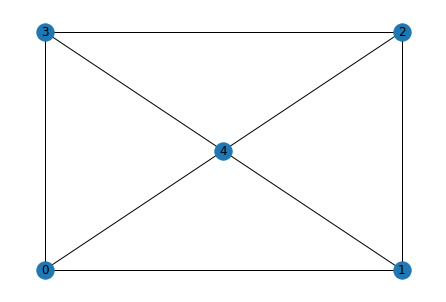

In [21]:
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(3,0),(0,4),(1,4),(2,4),(3,4)])

pos = {0: (0,0), 1: (2,0), 2: (2,2), 3: (0,2), 4: (1,1)}

nx.draw(G,pos, with_labels=True)

**3 methods for solving the problem**

**Method 1**
Solve the system of linear equations $x_i=\sum_j P_{ij} x_j$ for every regular node $i$..

**Method 2**
Run the French-DeGroot dynamics until convergence.

**Method 3**
Use Series, parallel, and gluing laws.

We skip Method 1, let us start with **Method 2**.

In [22]:
# Number of iterations
n_iter = 50;

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

n_nodes = G.number_of_nodes()

stubborn = [0,4];
regular = [node for node in G.nodes if node not in stubborn]

print("Stubborn nodes:", stubborn, "\n")
print("Regular nodes:", regular, "\n")

# Input to stubborn nodes
u = [0,1]

# Submatrices
Q = P[np.ix_(regular, regular)]
E = P[np.ix_(regular, stubborn)]

# Set the initial condition for the dynamics
x = np.zeros((n_nodes,n_iter))
x[stubborn,0] = u;
print("Initial condition:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular, t] = Q @ x[regular, t-1] + E @ x[stubborn, t-1]
    x[stubborn, t] = x[stubborn, t-1];

x_final = x[:,n_iter-1]
print("final opinions:", x_final)

Stubborn nodes: [0, 4] 

Regular nodes: [1, 2, 3] 

Initial condition: [0. 0. 0. 0. 1.] 

final opinions: [0.         0.57142857 0.71428571 0.57142857 1.        ]


**Method 3**

Note by symmetry that $x_1 = x_3$, then we can operate **gluing**

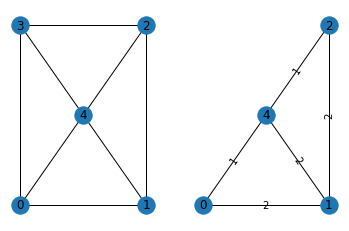

In [23]:
G1 = nx.Graph()
G1.add_edges_from([(0,1),(1,2),(0,4),(1,4),(2,4)])

labels = ['2','1','2','2','1']

zip_operator = zip(G1.edges(), labels)
labels = dict(zip_operator)

plt.subplot(121)
nx.draw(G,pos, with_labels=True)
plt.subplot(122)
nx.draw_networkx_edge_labels(G1,pos,edge_labels = labels)
nx.draw(G1,pos, with_labels=True)

The new node 1 is the result of gluing 1 and 3.

We thus have conductances:

$$
\begin{cases}
c_{04} = c_{24} = 1, \\
c_{01} = c_{12} = c_{14} = 2.
\end{cases}
$$

We operate a series composition of edges $(2,4)$ and $(1,2)$, plus a parallel composition of the resulting link with $(1,4)$. The resulting conductance $c_{14}$ is

$$
c'_{14} = (c^{-1}_{24}+c_{21}^{-1})^{-1} + c_{14} = (2^{-1}+1^{-1})^{-1} + 2 = 2/3 + 2 = 8/3
$$

and the resulting network is:

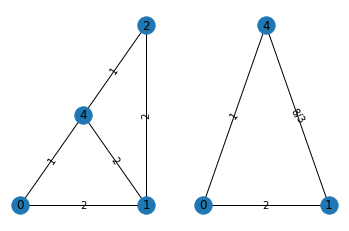

In [24]:
G2 = nx.Graph()
G2.add_edges_from([(0,1),(0,4),(1,4)])

# plot old graph
plt.subplot(121)
nx.draw_networkx_edge_labels(G1,pos,edge_labels = labels)
nx.draw(G1,pos, with_labels=True)

# plot new graph
plt.subplot(122)

labels = ['2','1','8/3']
zip_operator = zip(G2.edges(), labels)
labels = dict(zip_operator)
nx.draw_networkx_edge_labels(G2,pos,edge_labels = labels)
nx.draw(G2,pos, with_labels=True)

We have conductances:

$$
\begin{cases}
c_{04} = 1, \\
c_{14} = (1/2 + 1)^{-1} + 2 = 8/3, \\
c_{01} = 2.
\end{cases}
$$

The resulting conductance of the series of links $(0,1)$ and $(1,4)$ is $(1/2+3/8)^{-1} = 8/7$.

Using the fact that $x_0 = 0, x_4 = 1$, by Ohm's law, $\phi_{41}=\phi_{10}=8/7$.

Using again Ohm's law:

$$
2(x_1-x_0) = \phi_{10} \implies x_1 = 8/14 = 4/7 
$$

Moreover, by symmetry, $x_3 = x_1 = 4/7$.

Finally, by Kirchhoff's law on $G1$ (current entering node 2 is equal to the current leaving node 2),

$$
(x_4 - x_2)C_{24} = (x_2-x_1)C_{12} \implies x_2 = \frac{x_4 C_{24} + x_1C_{12}}{C_{24}+C_{12}} = \frac{1+\frac{4}{7}\cdot2}{1+2} = \frac{5}{7},
$$

which is equivalent to what obtained by French-DeGroot dynamics.

In [25]:
# voltage
x = np.array([0,4/7,5/7,4/7,1])

print('voltage:', x)

voltage: [0.         0.57142857 0.71428571 0.57142857 1.        ]


Voltage is equivalent to asymptotic opinions in French-DeGroot dynamics with stubborn nodes.

We can thus apply techniques from De Groot dynamics (e.g., iterative implementation of the dynamics) to find the voltage in electrical network, or apply techinques from electrical networks (e.g., series and parallel composition, gluing, Ohm's law) to find asymptotic opinions in De Groot dynamics.

# <mark>Markov chains</mark>

## A first example: Random Walks on graphs and flow dynamics
In this section we study a first example of discrete time Markov chain, which is the simple random walk on a graph, and we analyse the connection between random walks and flow dynamics.

To explore such connections we first learn how to simulate a random walk.

### <span style="background-color: #00FF00">Simple Random Walk</span>

A random walker on a graph $\mathcal G$ is an agent that starts at the initial time $0$ at some node and at each time moves from the current position to a neighboring one, chosen with uniform probability (this can be generalized).

To learn how to simulate a random walk, here we consider the example of a $n \times n$ chessboard with a single knight on it. 
1. We construct a network $G$ with all knight's possible moves. In this network nodes represent chessboard locations and an edge between two locations is present if the knight is admitted to move from one to another. (Note that the resulting graph is undirected).
2. We implement a simulation of the knight's random walk on the chessboard network $G$.

In [6]:
from numpy.random import choice, rand 

#### The Knight's Network

Here we define function `GenerateKnightNetwork` that constructs the knight's network. 
It exploits two auxiliary functions, `ApplyLegalMoves` and `isLegalPos`.

In [27]:
# Determines if the position obtained applying a move is legal,
# i.e. if it is inside the chessboard
def isLegalPos(x,boardSize):
    if x >= 0 and x < boardSize:
        return True
    else:
        return False
    
# Apply the knight's legal moves to the current position to construct
# neighboring nodes in the knight's graph

def ApplyLegalMoves(x,y,boardSize):
    # will store the neighboring nodes
    new_positions = []
    
    # offsets describe the effect of the knight's legal moves
    # on the current position's row and column
    offsets = [(-1,-2),(-1,2),(-2,-1),(-2,1),
                   ( 1,-2),( 1,2),( 2,-1),( 2,1)]
    
    # for each legal move, compute the new position's row and column
    for off in offsets:
        new_x = x + off[0]
        new_y = y + off[1]
        
        # if the new position doesn't exceed the boardsize,
        # accept it as legal
        if isLegalPos(new_x,boardSize) and isLegalPos(new_y,boardSize):
            new_positions.append((new_x,new_y))
         
    return new_positions

# Generates the graph representing the knigth network.
# Return both the graph object G and the pos dictionary
# for drawing G.

def GenerateKnightNetwork(boardSize):
    # undirected graph G will store the knight's network
    G = nx.Graph()
    # when drawing G, the pos dictionary describes the position on 
    # a boardsize x boardsize grid where to place nodes
    pos = {}
    
    # we assign position to nodes
    # we have boardSize x boardSize nodes
    for row in range(boardSize):
        for column in range(boardSize):
            node_id = row + column*boardSize
            # pos[node_id] are the (x,y) coordinates of node node_id 
            # on a square grid of side boardSize
            pos[node_id] = np.array([1.0*row/boardSize, 1.0*column/boardSize])
            
            # compute the (row,column) of neighboring position to the
            # current one, i.e., positions on the chessoboard reachable
            # by applying legal moves
            neigh_pos = ApplyLegalMoves(row, column, boardSize)
            # for each neigbhoring position, compute the id and add
            # a link in G from current position node_id to neigh_id
            for p in neigh_pos:
                neigh_id = p[0] + p[1]*boardSize
                G.add_edge(node_id, neigh_id)
    return G, pos

We are now ready to generate an example of the knight's network, with a specified boardsize.

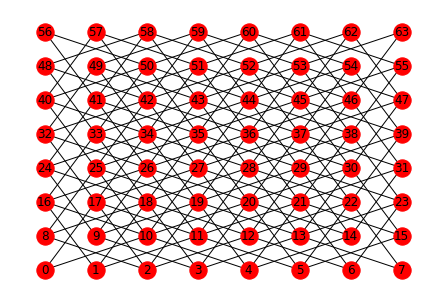

In [28]:
boardSize = 8
# use position dictionary returned by the function GenerateKnightNetwork
(G,pos) = GenerateKnightNetwork(boardSize)
nx.draw(G,pos, with_labels=True, node_color='red')

#### Simulate the Random Walk Process
Now that we have the graph $G$ representing the knight's network, we can simulate the knight's random walk on it. 

The walk starts at some given node and it can either terminate after a specified number of steps or when it first returns to the starting node.

At each step, the walker is at some node `xi` and has to decide which node to visit next. 

<span style="background-color: #FFA07A">In this simple version of the random walk, he does it by choosing a neighbor of the current node uniformly at random.
More formally, he looks at row `xi` of the normalized weight matrix $P$ of the graph $G$ and interprets the numbers on that row as the probability of visiting the corresponding nodes next, given that he currently is at `xi`.</span>

To simulate the random walk we define the function `RandomWalk`, which allows to specify the graph $G$ on which the walk takes place, the starting node and the stopping criterion.

**Remark 1**: the `RandomWalk` function is independent on the specific example we are studying. In other words, it allows to simulate any simple random walk on any **unweighted** graph $G$, since it only exploits the general features of the stochastic process at hand.

In [4]:
# Simulates a random walk on the graph G, starting from node xi.
# if till_first_return = True the random walk stops the first time
# it returns to the starting node xi.
# Otherwise, it goes on for num_steps steps.

# N.B.: nodes id according to their identifier (appearing in nx.Graph.adj)

def RandomWalk(G, xi, num_steps, till_first_return = False):
    # nodeSeq stores the sequence of visited nodes
    nodeSeq = []
    nodeSeq.append(xi)
    
    # if the walk ends at the first return to xi
    if till_first_return:
        # stores the initial position to check if the 
        # walk returns to it
        x_init = xi
        
        # no upper bound on the number of steps
        while True:
            # compute the next visited node xi by chosing uniformly
            # at random a neighbor of the current one
            xi = choice(G.adj[xi],1)[0]     # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
            nodeSeq.append(xi)
            
            # check if the walk has returned to the starting node
            # if so, end the walk
            if xi == x_init:
                return nodeSeq
    
    # if the walk ends after num_steps steps
    else:
        for i in range(num_steps):
            xi = choice(G.adj[xi],1)[0]      
            nodeSeq.append(xi)
        return nodeSeq

You can implement RandomWalk with different stopping criteria, or using non-uniform transition probability distributions (for weighted graph, as we shall see later on).

As a first experiment, we simulate a simple random walk on $G$ with $10$ steps.

Node sequence: [0, 17, 27, 10, 27, 17, 32, 26, 20, 5, 20]


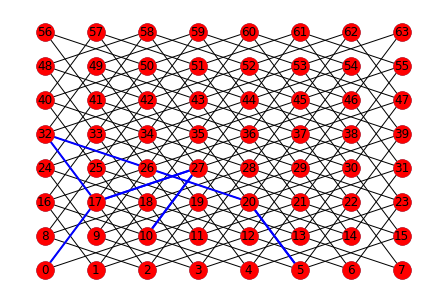

In [30]:
# Simulate a random walk on G 
nodeSeq = RandomWalk(G, xi=0, num_steps=10, till_first_return=False)
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(G, pos)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(G, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

print("Node sequence:", nodeSeq)

Node sequence: [0, 17, 27, 17, 32, 26, 16, 33, 27, 17, 11, 5, 11, 28, 22, 37, 52, 46, 63, 46, 61, 55, 45, 28, 34, 40, 25, 10, 27, 33, 50, 56, 41, 56, 50, 33, 48, 33, 43, 26, 41, 58, 52, 46, 36, 19, 4, 14, 20, 14, 31, 46, 36, 21, 11, 28, 11, 21, 15, 21, 27, 21, 27, 10, 16, 10, 20, 5, 11, 26, 36, 21, 31, 46, 31, 14, 31, 46, 52, 35, 29, 12, 29, 23, 29, 14, 20, 3, 18, 8, 2, 17, 27, 21, 15, 21, 38, 55, 38, 53, 47, 62, 52, 42, 25, 10, 20, 5, 15, 30, 47, 37, 31, 21, 27, 21, 36, 21, 27, 37, 43, 26, 9, 24, 41, 24, 34, 40, 25, 8, 2, 19, 13, 19, 36, 30, 13, 3, 18, 24, 41, 26, 41, 51, 45, 62, 45, 60, 54, 37, 22, 39, 45, 62, 52, 62, 45, 62, 45, 35, 45, 55, 45, 28, 45, 28, 13, 3, 18, 24, 18, 35, 25, 42, 48, 42, 57, 51, 41, 26, 32, 42, 27, 21, 38, 53, 43, 49, 59, 49, 43, 26, 43, 53, 63, 53, 38, 44, 54, 60, 45, 60, 45, 28, 45, 30, 36, 30, 13, 19, 2, 17, 0]


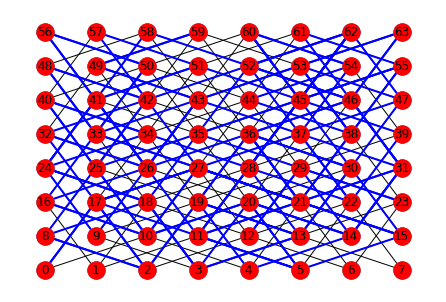

In [31]:
# Simulate a random walk on G that stops at the first return time
# note that if till_first_return = True, 'num_steps' is negligible
nodeSeq = RandomWalk(G, xi=0, num_steps=1, till_first_return=True)
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(G, pos)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(G, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

# if the node sequence is not deducible from the plot, you can print the nodeSeq
print("Node sequence:", nodeSeq)

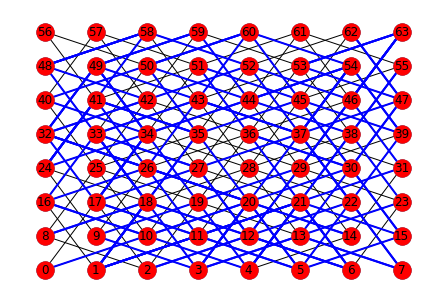

In [32]:
# Simulate a random walk on G with 200 steps
nodeSeq = RandomWalk(G, xi=0, num_steps=200, till_first_return=False)
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(G, pos)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(G, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

Note that even with a larger number of steps some of the nodes may not be visited!

**Question**: do you think that all the nodes have the same probability of being visited?

To answer this question, we need to relate random walks to flow dynamics.

### <span style="background-color: #00FF00">Random Walks and the Flow Dynamics</span>

The random walk and the flow dynamics are deeply connected. Indeed, if we describe the position of the walker on $G$ at time $t$ with a random variable $x(t)$, the variable's probability distribution evolves according to a flow dynamics. Let

$$
\pi_i(t) = \mathbf{P}\{x(t)=i\}.
$$

Then,

$$
\pi(t+1) = P'\pi(t)
$$

or more explicitly

$$
\pi_j(t+1) = \sum_{i \in \mathcal V} P_{ij}\pi_i(t),
$$

Moreover, one can use a random walk to estimate the invariant measure $\pi$ of the graph $G$ (assume here $G$ is strongly connected). Indeed, by the Katz theorem, the fraction of time spent by the walker on each node tends to the node's value in the invariant measure $\pi$ as the length of the walk increases.

The following section shows how to compute empirical frequencies and how to compare them with the inviariant distribution of $G$.

#### Empirical frequencies and invariant distribution
The empirical frequencies are the fractions of total walk time that each node of G is visited in the random walk. 

They can be represented by a histogram as follows.

We simulate random walks starting at each node of $G$, and we keep track of the sequence of visited nodes. 

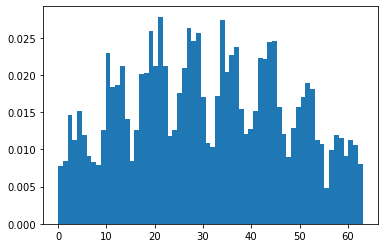

In [33]:
import matplotlib.pyplot as plt

# nodeSeq: list to store all random walks
nodeSeq = []

# simulate one random walk for each initial node in G
for xi in range(G.number_of_nodes()):
    # list.extend extends the list by appending all the items from an iterable
    nodeSeq.extend(RandomWalk(G, xi, 100))
    
# plt.hist computes and draws the histogram of nodeSeq. We have one bin for each node,
# so each bin width is 1 and the number of observations in each bin equals the number
# of visits to the correspnding node. 
# Since density=True, the return element will be the counts normalized 
# to form a probability density.
h = plt.hist(nodeSeq, bins = G.number_of_nodes(), density=True)

In order to use empirical frequencies to approximate the invariant measure of $G$, we have to construct long random walks. As an example, here we run a random walk with $10000$ steps for each initial condition.

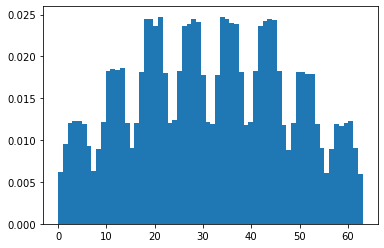

In [34]:
# nodeSeq: list to store all random walks
nodeSeq = []

# simulate one random walk for each initial node in G
for xi in range(G.number_of_nodes()):
    # list.extend extends the list by appending all the items from an iterable
    nodeSeq.extend(RandomWalk(G, xi, 10000))
    
# plt.hist computes and draws the histogram of nodeSeq. We have one bin for each node,
# so each bin width is 1 and the number of observations in each bin equals the number
# of visits to the correspnding node. 
# Since density=True, the return element will be the counts normalized 
# to form a probability density.
h = plt.hist(nodeSeq, bins = G.number_of_nodes(), density=True)

The frequencies are now more smooth, and look not uniform, as expected. Let us compare frequencies with the invariant distribution of the graph.

In [35]:
# Simulate a "long" random walk

nodeSeq = RandomWalk(G, 0, 100000, False)

# Compute empirical frequencies

frequencies = np.zeros(len(G))
# count the visits to each node
for node in nodeSeq:
    frequencies[node] += 1
# normalize the counts to obtain frequencies
frequencies /= len(nodeSeq)
print("Frequencies:", frequencies, "\n")

Frequencies: [0.00641994 0.00875991 0.01279987 0.01166988 0.01259987 0.01179988
 0.00895991 0.00591994 0.00900991 0.01196988 0.01922981 0.01747983
 0.01824982 0.01780982 0.01235988 0.00914991 0.01160988 0.01860981
 0.02377976 0.02372976 0.02436976 0.02456975 0.01796982 0.01153988
 0.01202988 0.01804982 0.02446976 0.02404976 0.02358976 0.02356976
 0.01794982 0.01242988 0.01218988 0.01698983 0.02332977 0.02333977
 0.02313977 0.02451975 0.01768982 0.01173988 0.01174988 0.01716983
 0.02323977 0.02356976 0.02372976 0.02403976 0.01821982 0.01190988
 0.00825992 0.01148989 0.01708983 0.01703983 0.01768982 0.01690983
 0.01255987 0.00887991 0.00577994 0.00887991 0.01100989 0.01160988
 0.01245988 0.01186988 0.00940991 0.00598994] 



In [36]:
# sort the nodes to compare empirical frequencies with invariant distribution
H = nx.Graph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))

print(H.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [37]:
# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

# Compute invariant distribution
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)

print("pi=", pi, "\n")

print("frequencies=", frequencies, "\n")

# Evaluate the approximation error by computing the norm of
# the difference between the empirical frequencies and the 
# invariant measure
error = np.linalg.norm(frequencies-pi)
print("Error", error)

pi= [0.00595238 0.00892857 0.01190476 0.01190476 0.01190476 0.01190476
 0.00892857 0.00595238 0.00892857 0.01190476 0.01785714 0.01785714
 0.01785714 0.01785714 0.01190476 0.00892857 0.01190476 0.01785714
 0.02380952 0.02380952 0.02380952 0.02380952 0.01785714 0.01190476
 0.01190476 0.01785714 0.02380952 0.02380952 0.02380952 0.02380952
 0.01785714 0.01190476 0.01190476 0.01785714 0.02380952 0.02380952
 0.02380952 0.02380952 0.01785714 0.01190476 0.01190476 0.01785714
 0.02380952 0.02380952 0.02380952 0.02380952 0.01785714 0.01190476
 0.00892857 0.01190476 0.01785714 0.01785714 0.01785714 0.01785714
 0.01190476 0.00892857 0.00595238 0.00892857 0.01190476 0.01190476
 0.01190476 0.01190476 0.00892857 0.00595238] 

frequencies= [0.00641994 0.00875991 0.01279987 0.01166988 0.01259987 0.01179988
 0.00895991 0.00591994 0.00900991 0.01196988 0.01922981 0.01747983
 0.01824982 0.01780982 0.01235988 0.00914991 0.01160988 0.01860981
 0.02377976 0.02372976 0.02436976 0.02456975 0.01796982 0.011539

**Observation** Note how important the invariant distribution is. So far, it appeared in many different contexts:
- centrality measures in social networks;
- consensus value in averaging dynamics;
- asymptotic limit of linear flow dynamics;
- invariant probability distributions in random walks.

### Exercise
Consider the graph shown in the following picture:
![Exgraph](graph1.png)

**Remark 2**: for nodes without out-going links, follow the convention and add a self-loop.

1. For each node of $G$, simulate the simple random walk starting from that node. What do you observe? How can you justify your observations?
2. Study the graph $G$ and compute its invariant measures. Can you see any relation with the behavior of the random walk?
3. Substitute the link (5,1) with the link (1,5) and repeat the analysis performed at point 1. and 2. What topological property of the graph has changed? How does this reflect on the random walk process?

Start: 2
Node sequence: [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Start: 1
Node sequence: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Start: 5
Node sequence: [5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Start: 3
Node sequence: [3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Start: 4
Node sequence: [4, 3, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Start: 6
Node sequence: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


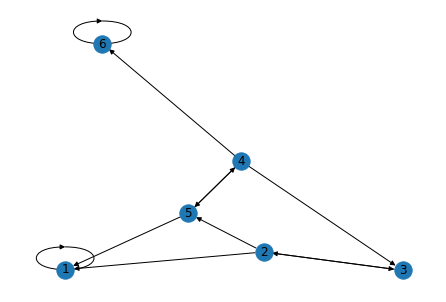

In [12]:
G = nx.DiGraph()
G.add_edges_from([(2,1),(2,5),(2,3),(3,2),(4,3),(4,5),(4,6),(5,1),(5,4)])
G.add_edges_from([(1,1),(6,6)]) # self loops
nx.draw(G, with_labels=True)

for x in list(G.nodes): 
    print("Start:", x)
    nodeSeq = RandomWalk(G, xi=x, num_steps=20, till_first_return=False)
    edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

    print("Node sequence:", nodeSeq)

When the walker reaches node 1 or 6, he stay there forever.

Condensation graph:
{0: {'members': {1}}, 1: {'members': {6}}, 2: {'members': {2, 3, 4, 5}}}


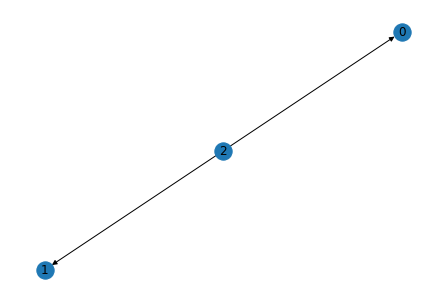

In [13]:
CG = nx.algorithms.components.condensation(G)
nx.draw(CG, with_labels=True)

print("Condensation graph:")
print(dict(CG.nodes))

2 sinks in the condensation graph: $0$ (with node 1) and $1$ (with node 6).          
$\mathcal{W}_0 = \{1\}$ and  $\mathcal{W}_1 = \{6\}$

In [14]:
# sort the nodes
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))

# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A
w,v = np.linalg.eig(P.T)

for i in range(len(G)):
    print(i+1)
    print("eigenvalue: ", w[i])
    print("eigenvector: ", v[i])
    print()
    
print("\nInvariant distributions pi:")
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi) # normalization
    print("pi"+str(index+1), "=", pi)

1
eigenvalue:  (1+0j)
eigenvector:  [ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.00787951+0.00000000e+00j  0.82535454+0.00000000e+00j
 -0.2236068 +3.00335586e-09j -0.2236068 -3.00335586e-09j]

2
eigenvalue:  (1+0j)
eigenvector:  [ 0.        +0.j  0.        +0.j  0.66523836+0.j -0.35193685+0.j
  0.67082039+0.j  0.67082039-0.j]

3
eigenvalue:  (-0.7071067811865483+0j)
eigenvector:  [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -4.70394558e-01+0.00000000e+00j -2.48856931e-01+0.00000000e+00j
  9.05078716e-17+4.50503379e-09j  9.05078716e-17-4.50503379e-09j]

4
eigenvalue:  (0.7071067811865475+0j)
eigenvector:  [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.33261918+0.00000000e+00j -0.17596842+0.00000000e+00j
 -0.67082039-1.55725822e-24j -0.67082039+1.55725822e-24j]

5
eigenvalue:  (-7.782728374119322e-18+6.715707866030684e-09j)
eigenvector:  [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -4.70394558e-01+0.00000000e+00j -2.

$\pi_1$ is such that ${\pi_1}_i>0$ if and ony if $i \in \mathcal{W}_0$           
$\pi_2$ is such that ${\pi_2}_i>0$ if and ony if $i \in \mathcal{W}_1$

Start: 2
Node sequence: [2, 1, 5, 4, 3, 2, 3, 2, 5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Start: 1
Node sequence: [1, 5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Start: 5
Node sequence: [5, 4, 5, 4, 3, 2, 3, 2, 1, 5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Start: 3
Node sequence: [3, 2, 3, 2, 3, 2, 1, 5, 4, 3, 2, 5, 4, 5, 4, 3, 2, 5, 4, 6, 6]
Start: 4
Node sequence: [4, 3, 2, 1, 5, 4, 3, 2, 5, 4, 3, 2, 3, 2, 1, 5, 4, 3, 2, 5, 4]
Start: 6
Node sequence: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


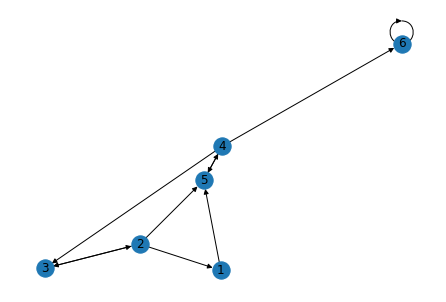

In [22]:
G = nx.DiGraph()
G.add_edges_from([(2,1),(2,5),(2,3),(3,2),(4,3),(4,5),(4,6),(1,5),(5,4)])
G.add_edges_from([(6,6)]) # self loops
nx.draw(G, with_labels=True)

for x in list(G.nodes): 
    print("Start:", x)
    nodeSeq = RandomWalk(G, xi=x, num_steps=20, till_first_return=False)
    edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

    print("Node sequence:", nodeSeq)

When the walker reaches node 6, he stay there forever.

Condensation graph:
{0: {'members': {6}}, 1: {'members': {1, 2, 3, 4, 5}}}


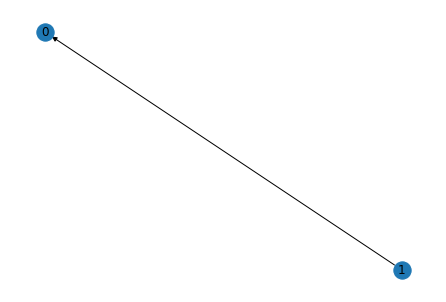

In [23]:
CG = nx.algorithms.components.condensation(G)
nx.draw(CG, with_labels=True)

print("Condensation graph:")
print(dict(CG.nodes))

1 sink in the condensation graph: $0$ (with node 6).          
$\mathcal{W}_0 = \{6\}$

In [24]:
# sort the nodes
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))

# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A
w,v = np.linalg.eig(P.T)

for i in range(len(G)):
    print(i+1)
    print("eigenvalue: ", w[i])
    print("eigenvector: ", v[i])
    print()
    
print("\nInvariant distributions pi:")
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi) # normalization
    print("pi"+str(index+1), "=", pi)

1
eigenvalue:  (1+0j)
eigenvector:  [ 0.        +0.j         -0.06608132+0.j         -0.29400747-0.07475265j
 -0.29400747+0.07475265j  0.21108486-0.19379956j  0.21108486+0.19379956j]

2
eigenvalue:  (0.9039359279143964+0j)
eigenvector:  [ 0.        +0.j         -0.17919983+0.j          0.62927316+0.j
  0.62927316-0.j          0.40426737+0.16302001j  0.40426737-0.16302001j]

3
eigenvalue:  (-0.6701232288361035+0.1703816807400984j)
eigenvector:  [ 0.        +0.j         -0.16198516+0.j         -0.42169056+0.10721662j
 -0.42169056-0.10721662j  0.01357504+0.22060615j  0.01357504-0.22060615j]

4
eigenvalue:  (-0.6701232288361035-0.1703816807400984j)
eigenvector:  [ 0.        +0.j         -0.26007279+0.j          0.16367752-0.43109008j
  0.16367752+0.43109008j -0.69831251+0.j         -0.69831251-0.j        ]

5
eigenvalue:  (0.21815526487890563+0.45772301505261j)
eigenvector:  [ 0.        +0.j         -0.23508914+0.j         -0.03623426+0.31677113j
 -0.03623426-0.31677113j -0.15234055-0.3196

$\pi_1$ is such that ${\pi_1}_i>0$ if and ony if $i \in \mathcal{W}_0$   

## <mark>Discrete time Markov chains</mark>
We already saw an example of discrete time Markov chain: the random walk on the knight's network.

In general, every discrete time Markov chain can be interpreted as a random walk on a weighted directed graph. So, in the general case, transition probabilities from each node to its neighbors are not uniformly distributed.

To better understand this notion, we analyse the following example.

![DMCgraph](discreteMC.png)

1. Construct the directed graph G with weights as shown in the picture.
2. Compute the invariant probability distribution vector by computing the leading eigenvector of $P'$.
3. Simulate a random walk starting from node 1 on the graph for n = 1000, 2000, 5000, 10000 steps. Determine the fraction of the steps the walk has been in each node i. Compare this with the invariant distribution. What do you observe?

**Hint:** you can adopt the function RandomWalk by modifying the choice of the next node to visit according to the fact that the transition probability is not uniform.

4. What happens with your estimate of $\pi$ if you remove node 5 and all links connected to it from the graph and add a self loop of weight 1 to node 6?
5. Compute the expected hitting time $\mathbb{E}_j[T_S]$, $\forall j \in R = \mathcal V \setminus \mathcal S$, for the set $S = \{2, 5\}$ analytically.
6. For every node i, simulate several times a random walk on G that begins in node i and stops when it comes back to it. Use this simulation to estimate the expected return time, $\mathbb{E}_i[T_i^+]$. Compare this estimate with the expected return times obtained analytically from the expected hitting times.

1.

P: [[0.         0.         0.33333333 0.66666667 0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [0.7        0.         0.         0.         0.         0.3       ]
 [0.         0.2        0.8        0.         0.         0.        ]
 [0.         0.         0.33333333 0.         0.66666667 0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


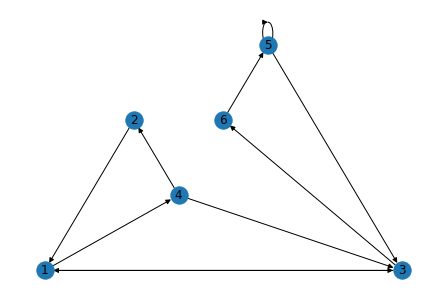

In [74]:
G = nx.DiGraph()

# add weighted edges
G.add_weighted_edges_from([(1,3,1),(1,4,2),(2,1,1),(3,1,7),(3,6,3),(4,2,1),(4,3,4),(5,5,2),(5,3,1),(6,5,1)])

# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))

pos = nx.planar_layout(H)
nx.draw(H, pos, with_labels=True)

# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

n_nodes = H.number_of_nodes()

print("P:", P)

2.

Condensation graph:
{0: {'members': {1, 2, 3, 4, 5, 6}}}


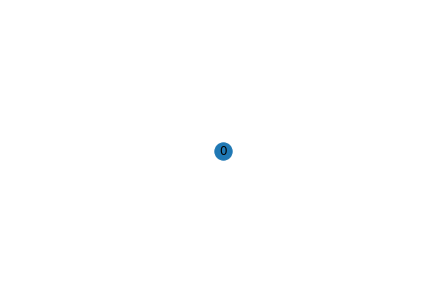

In [75]:
CG = nx.algorithms.components.condensation(H)
nx.draw(CG, with_labels=True)

print("Condensation graph:")
print(dict(CG.nodes))

Strongly connected graph.

In [76]:
w,v = np.linalg.eig(P.T)

for i in range(len(G)):
    print(i+1)
    print("eigenvalue: ", w[i])
    print("eigenvector: ", v[i])
    print()
    
print("\nInvariant distributions pi:")
inv_dist = []
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi) # normalization
    print("pi"+str(index+1), "=", pi)
    inv_dist.append(pi)

1
eigenvalue:  (-0.4498660664862174+0.6292904422317451j)
eigenvector:  [-6.20421471e-01+0.j         -6.20421471e-01-0.j
  4.78108171e-01+0.j         -2.96202514e-01+0.j
  4.85405093e-04-0.06410859j  4.85405093e-04+0.06410859j]

2
eigenvalue:  (-0.4498660664862174-0.6292904422317451j)
eigenvector:  [ 0.04473307-0.13080585j  0.04473307+0.13080585j  0.06374776+0.j
 -0.10677062+0.j          0.04890893+0.22813401j  0.04890893-0.22813401j]

3
eigenvalue:  (0.999999999999999+0j)
eigenvector:  [ 0.33481929-0.37088493j  0.33481929+0.37088493j  0.59194345+0.j
 -0.10482315+0.j         -0.05245931-0.32386018j -0.05245931+0.32386018j]

4
eigenvalue:  (0.6081880209771923+0j)
eigenvector:  [ 0.31095491+0.43497602j  0.31095491-0.43497602j  0.31873878+0.j
 -0.32468305+0.j         -0.22213808+0.02269418j -0.22213808-0.02269418j]

5
eigenvalue:  (-0.02089461066904546+0.19026397641457996j)
eigenvector:  [0.12244122+0.08869892j 0.12244122-0.08869892j 0.5327491 +0.j
 0.88418529+0.j         0.72079112+0.j   

$\pi_3$ is such that ${\pi_3}_i>0, \forall i$   since the graph is strongly connected


3.

In [77]:
# Simulates a random walk on the weighted graph G, starting from node xi.
# if till_first_return = True the random walk stops the first time
# it returns to the starting node xi.
# Otherwise, it goes on for num_steps steps.

# N.B.: nodes id according to matrix P (i.e., from 0 to n, referring to position of row/column in the matrix)

def RandomWalk_NotUniformTransitionProbability(G, xi, num_steps, till_first_return = False):
    # nodeSeq stores the sequence of visited nodes
    nodeSeq = []
    nodeSeq.append(xi)
    
    # if the walk ends at the first return to xi
    if till_first_return:
        # stores the initial position to check if the 
        # walk returns to it
        x_init = xi
        
        # no upper bound on the number of steps
        while True:
            # compute the next visited node xi by chosing uniformly
            # at random a neighbor of the current one
            xi = (choice(P[xi].shape[0], 1, p=P[xi])[0])     # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
            nodeSeq.append(xi)
            
            # check if the walk has returned to the starting node
            # if so, end the walk
            if xi == x_init:
                return nodeSeq
    
    # if the walk ends after num_steps steps
    else:
        for i in range(num_steps):
            xi = (choice(P[xi].shape[0], 1, p=P[xi])[0])    
            nodeSeq.append(xi)
        return nodeSeq

Node sequence: [1, 4, 2, 1, 3, 1, 3, 1, 3, 1, 4]


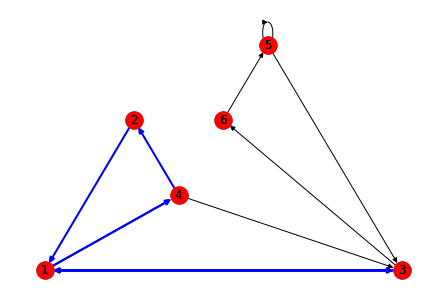

In [78]:
# Simulate a random walk on G 
start = 1
nodeSeq = RandomWalk_NotUniformTransitionProbability(H, xi=start-1, num_steps=10, till_first_return=False) # nodes start from 0
nodeSeq = [n+1 for n in nodeSeq] # nodes start from 1
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(H, pos, with_labels=True)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(H, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

print("Node sequence:", nodeSeq)

Node sequence: [1, 3, 1, 3, 1, 4, 3, 6, 5, 5, 5, 5, 3, 1, 4, 3, 6, 5, 5, 3, 1, 3, 1, 3, 6, 5, 5, 5, 5, 5, 5, 5, 3, 6, 5, 5, 5, 5, 3, 1, 3, 6, 5, 5, 3, 1, 4, 3, 1, 4, 2, 1, 3, 1, 4, 3, 6, 5, 5, 5, 3, 1, 4, 2, 1, 4, 3, 1, 3, 1, 4, 3, 6, 5, 5, 3, 6, 5, 3, 6, 5, 5, 5, 3, 6, 5, 5, 3, 1, 4, 3, 6, 5, 5, 3, 1, 3, 1, 4, 2, 1, 4, 3, 6, 5, 3, 6, 5, 3, 1, 3, 1, 4, 3, 1, 3, 1, 4, 3, 6, 5, 5, 3, 6, 5, 3, 1, 4, 2, 1, 4, 3, 1, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 3, 1, 4, 3, 6, 5, 3, 1, 4, 3, 1, 3, 1, 4, 3, 6, 5, 5, 5, 5, 3, 1, 3, 1, 4, 2, 1, 4, 3, 6, 5, 5, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 4, 2, 1, 3, 1, 3, 6, 5, 3, 1, 4, 2, 1, 4, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 5, 5, 3, 6, 5, 5, 3, 1, 4, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 6, 5, 5, 3, 1, 4, 3, 6, 5, 5, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 5, 3, 1, 4, 3, 1, 4, 3, 1, 3, 6, 5, 5, 5, 5, 3, 

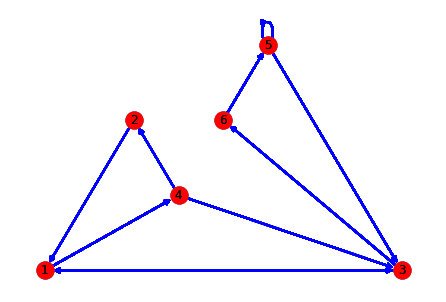

In [79]:
# Simulate a random walk on G 
start = 1
nodeSeq = RandomWalk_NotUniformTransitionProbability(H, xi=start-1, num_steps=1000, till_first_return=False) # nodes start from 0
nodeSeq = [n+1 for n in nodeSeq] # nodes start from 1
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(H, pos, with_labels=True)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(H, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

print("Node sequence:", nodeSeq)

Node sequence: [1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 3, 6, 5, 5, 5, 3, 1, 4, 3, 1, 4, 2, 1, 4, 2, 1, 4, 3, 1, 4, 3, 1, 3, 1, 4, 3, 1, 3, 1, 3, 1, 4, 2, 1, 3, 1, 3, 1, 3, 1, 4, 3, 6, 5, 5, 5, 5, 3, 6, 5, 3, 1, 4, 3, 6, 5, 5, 5, 5, 3, 1, 3, 6, 5, 5, 5, 5, 5, 3, 1, 4, 3, 1, 4, 3, 6, 5, 3, 1, 3, 1, 3, 6, 5, 3, 1, 4, 3, 6, 5, 5, 5, 3, 6, 5, 5, 5, 3, 6, 5, 5, 5, 5, 3, 1, 4, 3, 1, 3, 1, 3, 6, 5, 5, 5, 3, 6, 5, 3, 1, 3, 1, 4, 3, 6, 5, 5, 5, 5, 5, 3, 1, 4, 2, 1, 3, 6, 5, 5, 3, 1, 4, 2, 1, 4, 3, 6, 5, 3, 1, 4, 3, 1, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 2, 1, 3, 6, 5, 5, 3, 6, 5, 3, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 6, 5, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 5, 3, 1, 3, 6, 5, 3, 1, 4, 3, 1, 3, 6, 5, 5, 3, 1, 3, 1, 3, 1, 4, 3, 6, 5, 5, 5, 5, 3, 1, 4, 3, 1, 3, 1, 4, 3, 1, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 5, 5, 5, 5, 3, 1, 4, 3, 1, 4, 2, 1, 3, 1, 4, 2, 1, 4, 3, 1, 3, 1, 4, 3, 6, 5, 3, 1, 3, 1, 4, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 6, 5, 3, 1, 3, 1, 4, 3, 6, 5, 5, 5, 3, 6, 5, 3, 1, 4, 3, 6, 5, 5, 3, 1, 3, 

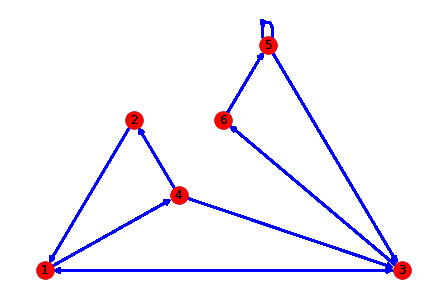

In [80]:
# Simulate a random walk on G 
start = 1
nodeSeq = RandomWalk_NotUniformTransitionProbability(H, xi=start-1, num_steps=2000, till_first_return=False) # nodes start from 0
nodeSeq = [n+1 for n in nodeSeq] # nodes start from 1
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(H, pos, with_labels=True)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(H, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

print("Node sequence:", nodeSeq)

Node sequence: [1, 4, 3, 6, 5, 5, 3, 1, 3, 1, 4, 3, 1, 4, 3, 1, 3, 6, 5, 5, 3, 1, 4, 2, 1, 3, 1, 4, 3, 6, 5, 5, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 4, 3, 6, 5, 5, 5, 3, 6, 5, 3, 6, 5, 3, 1, 4, 3, 1, 4, 3, 1, 4, 2, 1, 3, 1, 3, 1, 4, 3, 6, 5, 3, 6, 5, 5, 5, 3, 1, 3, 1, 3, 1, 3, 1, 4, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 6, 5, 5, 3, 1, 4, 3, 1, 4, 2, 1, 4, 3, 1, 4, 2, 1, 3, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 1, 4, 3, 1, 3, 1, 3, 1, 3, 6, 5, 3, 1, 3, 1, 3, 6, 5, 5, 3, 6, 5, 5, 5, 3, 1, 4, 3, 1, 3, 1, 4, 3, 6, 5, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 3, 6, 5, 5, 3, 6, 5, 5, 5, 5, 5, 5, 5, 3, 1, 4, 3, 6, 5, 5, 3, 1, 3, 6, 5, 5, 5, 5, 3, 6, 5, 5, 5, 5, 5, 5, 3, 1, 4, 2, 1, 4, 3, 6, 5, 5, 3, 6, 5, 5, 3, 6, 5, 5, 5, 5, 5, 3, 1, 3, 1, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 5, 5, 3, 1, 3, 6, 5, 3, 1, 4, 3, 1, 3, 1, 4, 3, 1, 3, 6, 5, 3, 1, 4, 3, 1, 3, 1, 3, 1, 4, 2, 1, 3, 1, 4, 3, 6, 5, 5, 3, 1, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 1, 4, 2, 1, 3, 1, 4, 3, 6, 5, 3, 1, 3, 1, 3, 1, 4, 2, 1, 3, 1, 3, 1, 3, 1, 4, 3, 

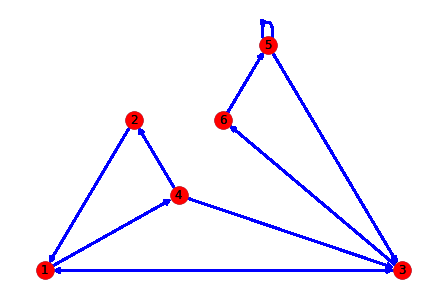

In [81]:
# Simulate a random walk on G 
start = 1
nodeSeq = RandomWalk_NotUniformTransitionProbability(H, xi=start-1, num_steps=5000, till_first_return=False) # nodes start from 0
nodeSeq = [n+1 for n in nodeSeq] # nodes start from 1
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(H, pos, with_labels=True)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(H, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

print("Node sequence:", nodeSeq)

Node sequence: [1, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 3, 6, 5, 5, 5, 5, 3, 1, 4, 3, 6, 5, 5, 3, 1, 3, 1, 3, 1, 3, 1, 4, 2, 1, 3, 1, 4, 3, 1, 4, 3, 6, 5, 3, 1, 3, 1, 4, 2, 1, 3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 4, 2, 1, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 5, 5, 5, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 4, 3, 6, 5, 3, 1, 4, 2, 1, 4, 2, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 4, 3, 1, 4, 3, 6, 5, 3, 6, 5, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 1, 3, 6, 5, 5, 3, 1, 3, 6, 5, 5, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 1, 3, 1, 3, 1, 4, 3, 1, 4, 3, 6, 5, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 3, 1, 4, 3, 6, 5, 5, 3, 1, 4, 2, 1, 3, 1, 4, 3, 6, 5, 3, 1, 4, 3, 6, 5, 3, 1, 4, 3, 6, 5, 5, 5, 5, 5, 5, 5, 3, 1, 3, 1, 4, 3, 1, 4, 3, 6, 5, 3, 1, 4, 2, 1, 4, 3, 1, 4, 3, 6, 5, 5, 5, 3, 1, 3, 6, 5, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 3, 1, 3, 1, 4, 3, 1, 4, 3, 6, 5, 5, 3, 1, 4, 3, 6, 5, 3, 6, 5, 5, 3, 1, 4, 3, 1, 3, 1, 4, 2, 1, 3, 1, 4, 3, 1, 3, 6, 5, 5, 3, 1, 4, 3, 1, 3, 6, 5, 5, 5, 5, 5, 5, 3, 1, 4, 

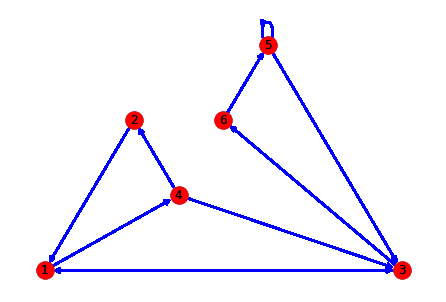

In [82]:
# Simulate a random walk on G 
start = 1
nodeSeq = RandomWalk_NotUniformTransitionProbability(H, xi=start-1, num_steps=10000, till_first_return=False) # nodes start from 0
nodeSeq = [n+1 for n in nodeSeq] # nodes start from 1
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(H, pos, with_labels=True)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(H, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

print("Node sequence:", nodeSeq)

In [83]:
frequencies = np.zeros(len(H))
# count the visits to each node
for node in nodeSeq:
    frequencies[node-1] += 1 # nodes start from 0
# normalize the counts to obtain frequencies
frequencies /= len(nodeSeq)
print("Frequencies:", frequencies, "\n")

Frequencies: [0.21827817 0.02809719 0.27407259 0.1409859  0.25457454 0.0839916 ] 



In [84]:
pi = inv_dist[0]
print("pi=", pi, "\n")

print("frequencies=", frequencies, "\n")

# Evaluate the approximation error by computing the norm of
# the difference between the empirical frequencies and the 
# invariant measure
error = np.linalg.norm(frequencies-pi)
print("Error", error)

pi= [0.22105263 0.02947368 0.27368421 0.14736842 0.24631579 0.08210526] 

frequencies= [0.21827817 0.02809719 0.27407259 0.1409859  0.25457454 0.0839916 ] 

Error 0.011056447457018354


4. If node 5 is removed, node 6 is a sink node. Hence, all random walks will eventually reach this node so that the estimate of the invariant measure will converge to $\pi =[0, 0, 0, 0, 1]$. You can check this by simulating the random walk on the modified graph.

The interpretation for this is that as the random walks hits 6, it cannot escape. Thus, from there on, it will stay in 6 forever. In the limit of infinite $t$, the fraction of time spent in node 6 tends to 1. This is coeherent with the fact that invariant distribution centrality in a graph has support only on nodes that belong to trapping set.

P: [[0.         0.         0.33333333 0.66666667 0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.7        0.         0.         0.         0.3       ]
 [0.         0.2        0.8        0.         0.        ]
 [0.         0.         0.         0.         1.        ]]


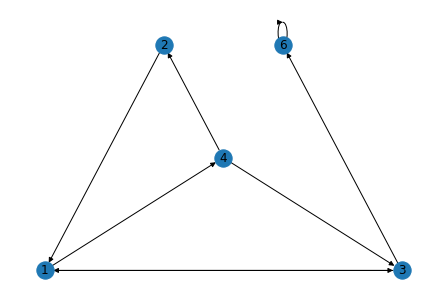

In [87]:
G = nx.DiGraph()

# add weighted edges
G.add_weighted_edges_from([(1,3,1),(1,4,2),(2,1,1),(3,1,7),(3,6,3),(4,2,1),(4,3,4),(5,5,2),(5,3,1),(6,5,1)])
G.remove_node(5)
G.add_weighted_edges_from([(6,6,1)])
# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))

pos = nx.planar_layout(H)
nx.draw(H, pos, with_labels=True)

# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

n_nodes = H.number_of_nodes()

print("P:", P)

Condensation graph:
{0: {'members': {6}}, 1: {'members': {1, 2, 3, 4}}}


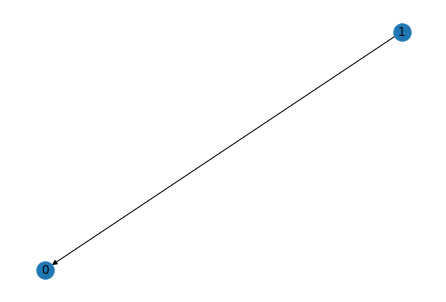

In [88]:
CG = nx.algorithms.components.condensation(H)
nx.draw(CG, with_labels=True)

print("Condensation graph:")
print(dict(CG.nodes))

In [89]:
w,v = np.linalg.eig(P.T)

for i in range(len(G)):
    print(i+1)
    print("eigenvalue: ", w[i])
    print("eigenvector: ", v[i])
    print()
    
print("\nInvariant distributions pi:")
inv_dist = []
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi) # normalization
    print("pi"+str(index+1), "=", pi)
    inv_dist.append(pi)

1
eigenvalue:  (1+0j)
eigenvector:  [ 0.00000000e+00+0.j -2.96485917e-01+0.j  6.39088456e-01+0.j
  6.39088456e-01-0.j  8.02434761e-18+0.j]

2
eigenvalue:  (0.8943462252355069+0j)
eigenvector:  [ 0.        +0.j         -0.04942327+0.j         -0.04423096+0.14376178j
 -0.04423096-0.14376178j  0.5568901 +0.j        ]

3
eigenvalue:  (-0.44717311261775305+0.6054403724657089j)
eigenvector:  [ 0.        +0.j        -0.30819685+0.j        -0.34507458+0.3473831j
 -0.34507458-0.3473831j -0.79555728+0.j       ]

4
eigenvalue:  (-0.44717311261775305-0.6054403724657089j)
eigenvector:  [ 0.00000000e+00+0.j         -2.21007561e-01+0.j
 -3.36301451e-01-0.45532808j -3.36301451e-01+0.45532808j
 -1.46177421e-16+0.j        ]

5
eigenvalue:  (3.7378399254812445e-17+0j)
eigenvector:  [1.        +0.j        0.87511359+0.j        0.08651854-0.0358168j
 0.08651854+0.0358168j 0.23866719+0.j       ]


Invariant distributions pi:
pi1 = [0. 0. 0. 0. 1.]


In [90]:
# Simulate a random walk on G 
start = 1
nodeSeq = RandomWalk_NotUniformTransitionProbability(H, xi=start-1, num_steps=100000, till_first_return=False) # nodes start from 0
nodeSeq = [n+1 for n in nodeSeq] # nodes start from 1
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

print("Node sequence:", nodeSeq)

Node sequence: [1, 3, 1, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [91]:
frequencies = np.zeros(len(H))
# count the visits to each node
for node in nodeSeq:
    frequencies[node-1] += 1 # nodes start from 0
# normalize the counts to obtain frequencies
frequencies /= len(nodeSeq)
print("Frequencies:", frequencies, "\n")

Frequencies: [1.99998e-05 0.00000e+00 1.99998e-05 9.99990e-06 9.99950e-01] 



In [92]:
pi = inv_dist[0]
print("pi=", pi, "\n")

print("frequencies=", frequencies, "\n")

# Evaluate the approximation error by computing the norm of
# the difference between the empirical frequencies and the 
# invariant measure
error = np.linalg.norm(frequencies-pi)
print("Error", error)

pi= [0. 0. 0. 0. 1.] 

frequencies= [1.99998e-05 0.00000e+00 1.99998e-05 9.99990e-06 9.99950e-01] 

Error 5.8308935859050836e-05


5. The expected hitting times  $\hat{x}= (\mathbb{E}_i[T_S])_{i \in R}$ for the set $S$ and for all nodes $i \in R = \mathcal V \setminus S$ is the expected value of $T_s$ for the random walk $X(t)$, assuming that the random walk starts in $i$, with hitting time:

$$
T_s = \min\{t \ge 0 \mid X(t) \in S\}
$$

It can be computed by solving the system of equations

$$
\hat{x} = \mathbf{1} + \hat{P}\hat{x},
$$ 

where $\hat{P}$ is obtained from $P$ (the normalized weight matrix of the graph) by removing the rows and columns corresponding to the nodes in the set $S$.

More explicitly, the expected hitting times can be expressed as

$$
\hat{x} = (I - \hat{P})^{-1} \mathbf{1}
$$

**Remark**: note that $(I - \hat{P})$ is invertible only if $V \setminus S$ has at least a link pointing to $S$. Indeed, if $(I - \hat{P})$ is not invertible. the random walk starting from nodes in $V \setminus S$ cannot hit nodes in $S$, and the hitting times diverge.

Thus, we get:

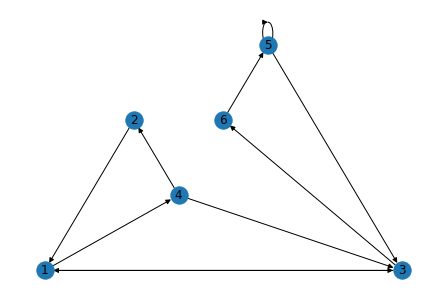

In [94]:
# Back to original graph

G = nx.DiGraph()

# add weighted edges
G.add_weighted_edges_from([(1,3,1),(1,4,2),(2,1,1),(3,1,7),(3,6,3),(4,2,1),(4,3,4),(5,5,2),(5,3,1),(6,5,1)])

# define a new graph with sorted nodes
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))

pos = nx.planar_layout(H)
nx.draw(H, pos, with_labels=True)

# Compute P matrix
A = nx.adjacency_matrix(H) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

n_nodes = H.number_of_nodes()


In [95]:
# Define the set S and the remaining nodes R
# Subtract -1 because indexes go from 0 to 5 and nodes from 1 to 6
S = [1, 4] # refer to nodes [2,5]
R = [node for node in range(n_nodes) if node not in S]

# Restrict P to R x R to obtain hat(P)
hatP = P[np.ix_(R, R)]

# solve the linear system to obtain hat(x)
# np.linalg.solve solves a linear matrix equation given
# the coefficient matrix and the dependent variable values
hatx = np.linalg.solve((np.identity(n_nodes-2)-hatP),np.ones(n_nodes-2))
# map node to position of node in hatx
map = {0: 0, 2: 1, 3: 2, 5: 3}

# define the hitting times to the set S
# hitting time is 0 if the starting node is in S
hitting_s = np.zeros(n_nodes)
# hitting time is hat(x) for nodes in R
for r in R:
    hitting_s[r] = hatx[map[r]]

print("hitting times:", hitting_s)

hitting times: [7.10169492 0.         6.27118644 6.01694915 0.         1.        ]


Notice that for node 6 the expected hitting time is 1, because its only outneighbour belongs to $S$.

6. The expected return times $\mathbb{E}_i[T_i^+]$ is the expected value of $T_i^+$ for the random walk $X(t)$, assuming that the random walk starts in $i$, with return time:

$$
T_i^+ = \min\{t \ge 1 \mid X(t) = i\}
$$

To compute expected return times analytically, recall that they can be caracterized by

$$
\mathbb{E}_i[T_i^+] = 1 + \sum_{j} P_{ij} \mathbb{E}_j[T_i]
$$

where $\mathbb{E}_j[T_i]$ is the expected hitting time to the set $S={i}$ starting from $j$.

So, for computing $\mathbb{E}_i[T_i^+]$, one can:
- set $S=\{i\}$
- compute the expected hitting times to $S$, $\mathbb{E}_j[T_i]$, $\forall j \in V\setminus \{i\}$ (as done in point 5)
- apply the linear relation $\mathbb{E}_i[T_i^+] = 1 + \sum_{j} P_{i,j} \mathbb{E}_j[T_i]$

Instead, an estimation of the expected return time $\mathbb{E}_i[T_i^+]$, $\forall i$, is obtained by simulating random walks that start at $i$ and end at the first return (you can use `RandomWalk(G, xi=i, num_steps = 'inf', till_first_return = True)`)

Implement and compare the two approaches.

In [120]:
def hitting_time(G, S, P):
    n_nodes = G.number_of_nodes()
    R = [node for node in range(n_nodes) if node not in S]


    hatP = P[np.ix_(R, R)]

    hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),np.ones(n_nodes-len(S)))
    # map node to position of node in hatx
    map = {}
    for i in range(n_nodes-len(S)):
        map[R[i]] = i


    hitting_s = np.zeros(n_nodes)

    for r in R:
        hitting_s[r] = hatx[map[r]]

    return hitting_s

In [155]:
ht = np.column_stack(tuple(hitting_time(G,[i], P) for i in range(len(G))))
return_i = np.diag(P@ht)+1
print("return times:", return_i)
return_i__analytically = return_i

return times: [ 4.52380952 33.92857143  3.65384615  6.78571429  4.05982906 12.17948718]


In [153]:
a = []
for i in range(0, len(G)):
    coll_rt = []
    for j in range(0, 100000):
        rt = len(RandomWalk_NotUniformTransitionProbability(H, xi=i, num_steps = 'inf', till_first_return = True))-1
        coll_rt.append(rt)
    avg_rt = sum(coll_rt)/len(coll_rt)
    a.append(avg_rt)
return_i = np.array(a)
print("return times:", return_i)
return_i__estimation = return_i

return times: [ 4.52141 33.90689  3.66069  6.7989   4.08985 12.17304]


In [156]:
print("return times computed analytically =", return_i__analytically, "\n")

print("return times estimated =", return_i__estimation, "\n")

error = np.linalg.norm(return_i__analytically-return_i__estimation)
print("Error", error)

return times computed analytically = [ 4.52380952 33.92857143  3.65384615  6.78571429  4.05982906 12.17948718] 

return times estimated = [ 4.52141 33.90689  3.66069  6.7989   4.08985 12.17304] 

Error 0.040489088936405994
